In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import fiona
import shapely
import geopandas
import seaborn as sns
#import sklearn.cluster.DBSCAN
from datetime import datetime

def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [52]:
df = pd.read_csv('nyc_taxis.csv', low_memory=False)

In [53]:
#Question 2

# 1. Distance of trip
df['trip_distance_km'] = haversine_np(df['pickup_longitude'], df['pickup_latitude'],
                                      df['dropoff_longitude'], df['dropoff_latitude'])

# 2. Day of the week
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['day_of_week'] = df['pickup_datetime'].dt.day_name()

# 3. Average speed of trip
# Convert trip duration from seconds to hours
df['trip_duration_hours'] = df['trip_duration'] / 3600
df['average_speed_kmh'] = df['trip_distance_km'] / df['trip_duration_hours']

# Display the first few rows to check the new features
print(df[['trip_distance_km', 'day_of_week', 'average_speed_kmh']].head())

   trip_distance_km day_of_week  average_speed_kmh
0          1.497580      Monday          11.848984
1          1.804374      Sunday           9.797504
2          6.381090     Tuesday          10.815406
3          1.484566   Wednesday          12.457894
4          1.187842    Saturday           9.830418


Entries removed 47548


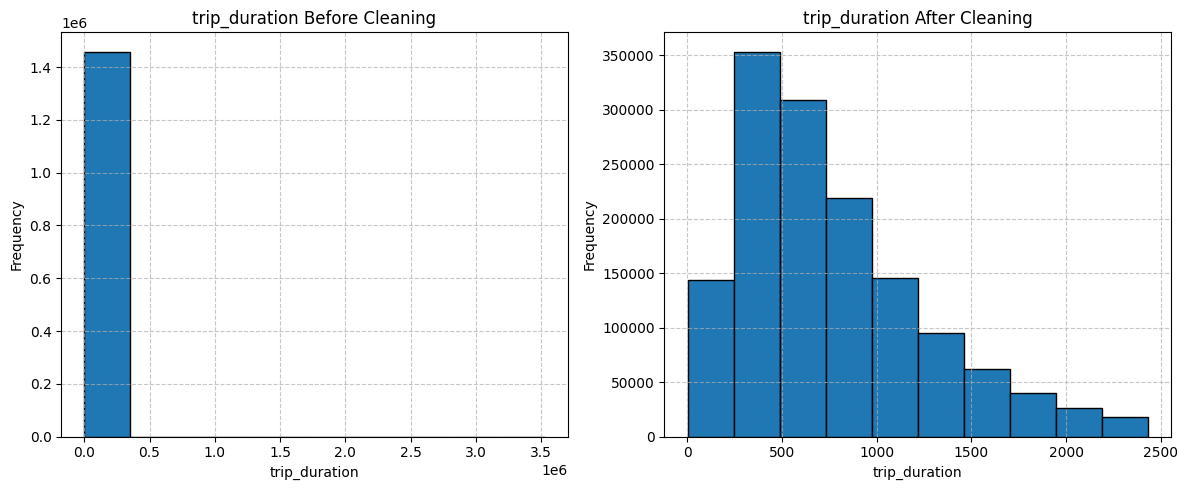

Entries removed 57595


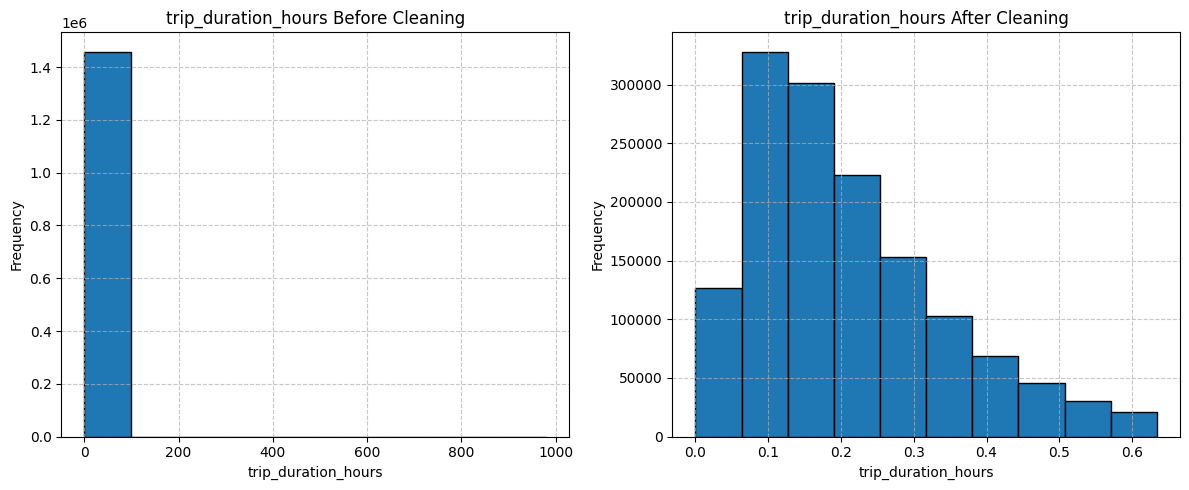

Entries removed 143254


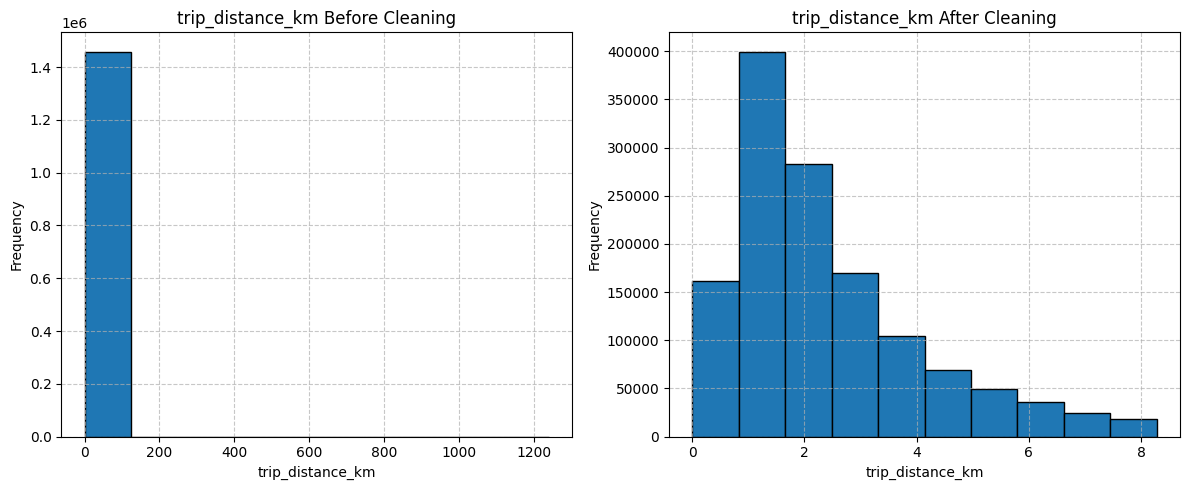

Entries removed 164027


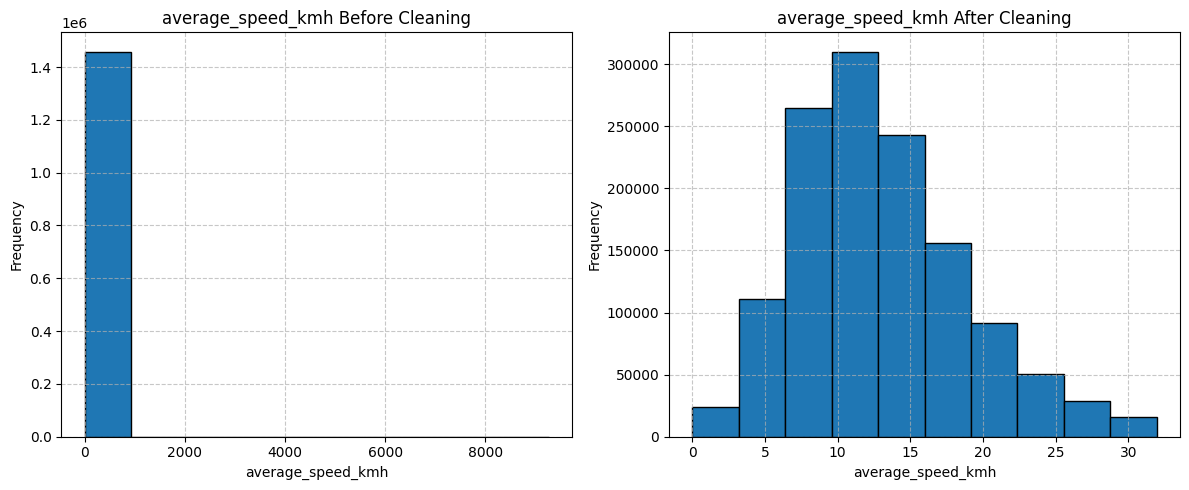

In [54]:

#Q1 
def clean_IQR(df_in, columns= [' ', ' ', ' ', ' ', ' ', ' '],iqr_scale = 1.5,plot = False):
    temp_df = df_in.copy()
    
    # Filter the DataFrame for the current currency
    
    for column in columns:
        Q1 = float(temp_df[column].quantile(0.25))
        Q3 = float(temp_df[column].quantile(0.75))
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_scale * IQR
        upper_bound = Q3 + iqr_scale * IQR

        # Filter the data based on the calculated bounds
        temp_df = temp_df[(temp_df[column] >= lower_bound) & (temp_df[column] <= upper_bound)]
        if (plot):
            print("Entries removed",df_in.shape[0]-temp_df.shape[0])
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.hist(df_in[column], bins=10, edgecolor='black')
            plt.title(f'{column} Before Cleaning')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.grid(True, linestyle='--', alpha=0.7)     
            
            plt.subplot(1, 2, 2)
            plt.hist(temp_df[column], bins=10, edgecolor='black')
            plt.title(f'{column} After Cleaning')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.grid(True, linestyle='--', alpha=0.7)   
            
            plt.tight_layout()
            plt.show()            

    # Update temp_df with the filtered country_df
    
    return temp_df      

df['trip_duration'] = df['trip_duration'].astype(int)
df = clean_IQR(df,columns=['trip_duration', 'trip_duration_hours', 'trip_distance_km','average_speed_kmh'],iqr_scale=2,plot=True)

In [55]:
import geopandas as gpd
from shapely.geometry import Point

# Read the shapefile
nyc_neighborhoods = gpd.read_file('2010 Neighborhood Tabulation Areas (NTAs)/geo_export_01b7a854-00a9-4a17-93fc-4e53946a61f0.shp')
print("Columns in nyc_neighborhoods:", nyc_neighborhoods.columns)

# Create GeoDataFrame for pickup locations
gdf_pickup = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.pickup_longitude, df.pickup_latitude))

# Create GeoDataFrame for dropoff locations
gdf_dropoff = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.dropoff_longitude, df.dropoff_latitude))

# Set the coordinate reference system (CRS) to match the neighborhoods shapefile
gdf_pickup.crs = nyc_neighborhoods.crs
gdf_dropoff.crs = nyc_neighborhoods.crs


# Spatial join for pickup locations
pickup_neighborhoods = gpd.sjoin(gdf_pickup, nyc_neighborhoods, how="left", predicate="within")

# Spatial join for dropoff locations
dropoff_neighborhoods = gpd.sjoin(gdf_dropoff, nyc_neighborhoods, how="left", predicate="within")

# Print columns of the joined dataframes
print("Columns in pickup_neighborhoods:", pickup_neighborhoods.columns)
print("Columns in dropoff_neighborhoods:", dropoff_neighborhoods.columns)

# Add neighborhood names to the original dataframe
# Use 'NTAName' if it's available, otherwise use another appropriate column
neighborhood_column = 'NTAName' if 'NTAName' in pickup_neighborhoods.columns else 'ntaname'

df['pickup_neighborhood'] = pickup_neighborhoods[neighborhood_column]
df['dropoff_neighborhood'] = dropoff_neighborhoods[neighborhood_column]

# Display the first few rows to check the new neighborhood columns
print(df[['pickup_neighborhood', 'dropoff_neighborhood']].head())

# Check for any trips where neighborhood couldn't be determined
print("Trips with undetermined pickup neighborhood:", df['pickup_neighborhood'].isna().sum())
print("Trips with undetermined dropoff neighborhood:", df['dropoff_neighborhood'].isna().sum())

Columns in nyc_neighborhoods: Index(['boro_code', 'boro_name', 'county_fip', 'ntacode', 'ntaname',
       'shape_area', 'shape_leng', 'geometry'],
      dtype='object')
Columns in pickup_neighborhoods: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'trip_distance_km', 'day_of_week',
       'trip_duration_hours', 'average_speed_kmh', 'geometry', 'index_right',
       'boro_code', 'boro_name', 'county_fip', 'ntacode', 'ntaname',
       'shape_area', 'shape_leng'],
      dtype='object')
Columns in dropoff_neighborhoods: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'trip_distance_km', 'day_of_week',
       'trip_duration_hours', 'average_sp

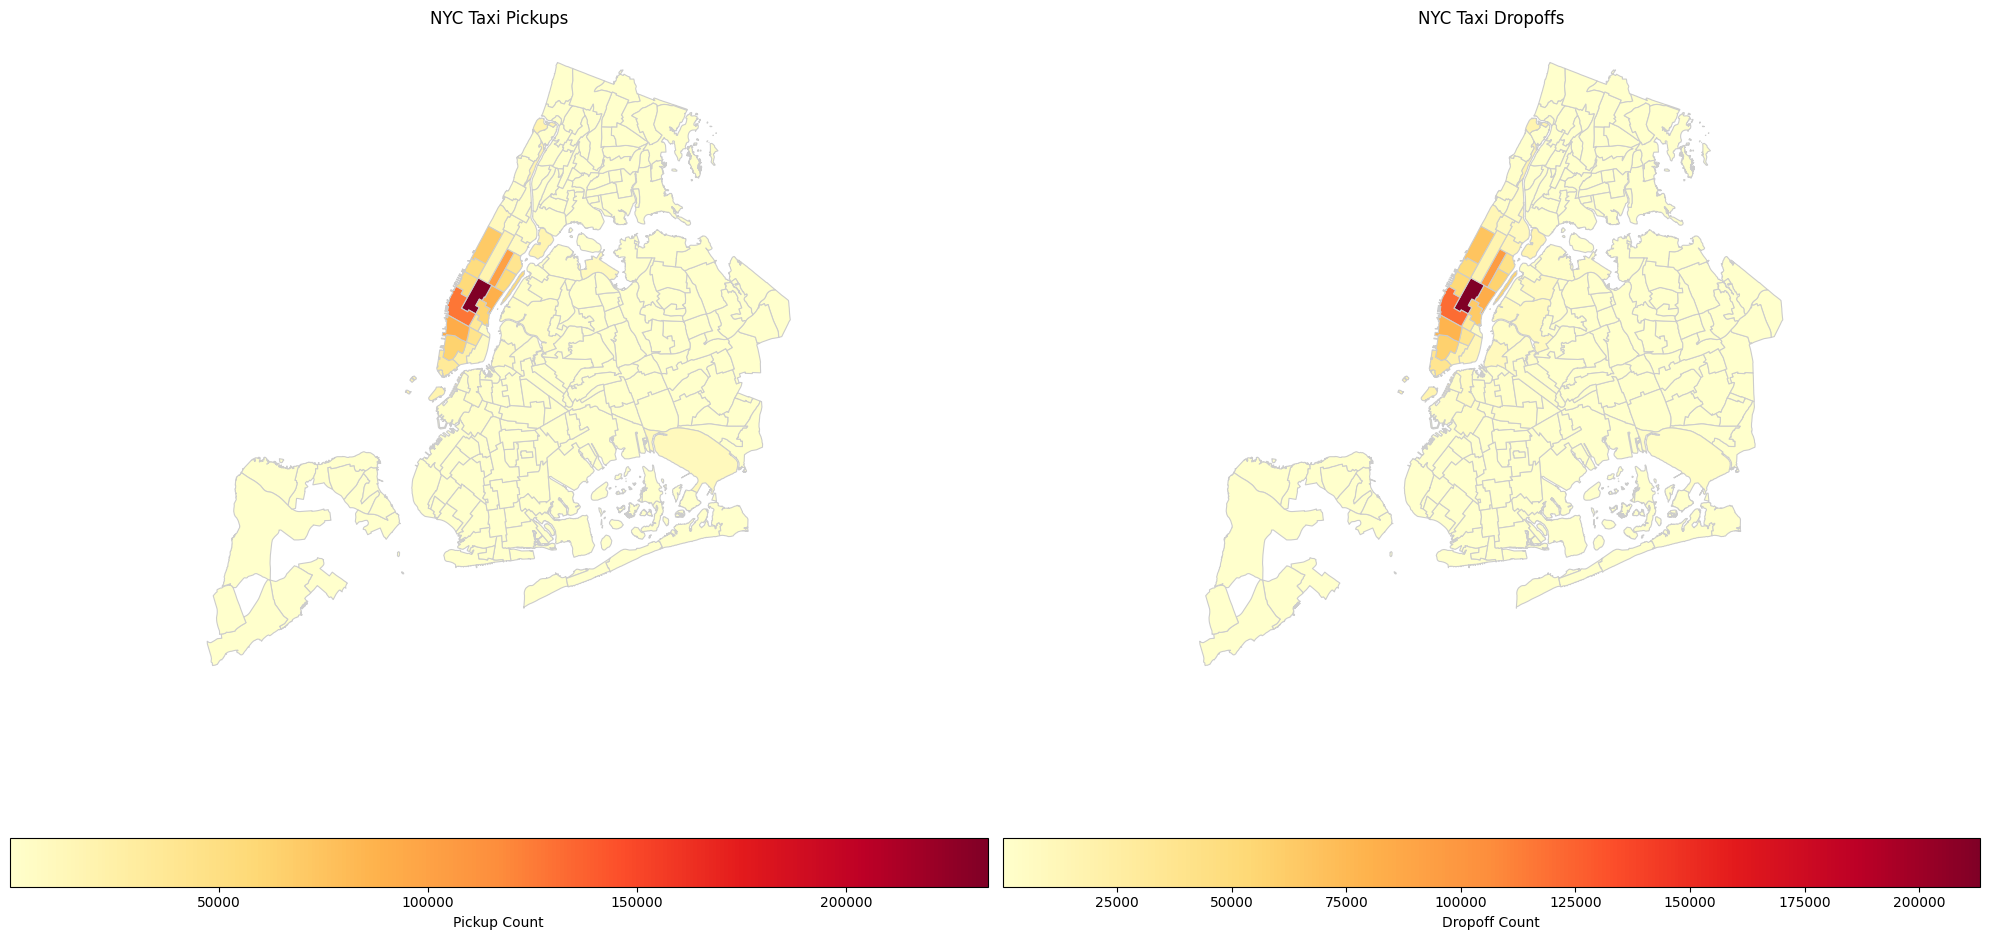

Total pickups: 1293540.0
Total dropoffs: 1292796.0
Neighborhood with most pickups: Midtown-Midtown South
Neighborhood with most dropoffs: Midtown-Midtown South


In [61]:
import matplotlib.pyplot as plt

# Assuming we already have nyc_neighborhoods, df, pickup_neighborhoods, and dropoff_neighborhoods from the previous step

# Count pickups and dropoffs per neighborhood
pickup_counts = pickup_neighborhoods[neighborhood_column].value_counts()
dropoff_counts = dropoff_neighborhoods[neighborhood_column].value_counts()

# Add these counts to the nyc_neighborhoods GeoDataFrame
nyc_neighborhoods['pickup_count'] = nyc_neighborhoods[neighborhood_column].map(pickup_counts)
nyc_neighborhoods['dropoff_count'] = nyc_neighborhoods[neighborhood_column].map(dropoff_counts)


# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot pickup chloropleth
nyc_neighborhoods.plot(column='pickup_count', ax=ax1, legend=True, 
                       cmap='YlOrRd', edgecolor='0.8', linewidth=0.8,
                       legend_kwds={'label': 'Pickup Count', 'orientation': 'horizontal'})
ax1.set_title('NYC Taxi Pickups')
ax1.axis('off')

# Plot dropoff chloropleth
nyc_neighborhoods.plot(column='dropoff_count', ax=ax2, legend=True, 
                       cmap='YlOrRd', edgecolor='0.8', linewidth=0.8,
                       legend_kwds={'label': 'Dropoff Count', 'orientation': 'horizontal'})
ax2.set_title('NYC Taxi Dropoffs')
ax2.axis('off')

plt.tight_layout()
plt.show()

# Print some statistics
print("Total pickups:", nyc_neighborhoods['pickup_count'].sum())
print("Total dropoffs:", nyc_neighborhoods['dropoff_count'].sum())
print("Neighborhood with most pickups:", nyc_neighborhoods.loc[nyc_neighborhoods['pickup_count'].idxmax(), neighborhood_column])
print("Neighborhood with most dropoffs:", nyc_neighborhoods.loc[nyc_neighborhoods['dropoff_count'].idxmax(), neighborhood_column])

The 10 quietest neighborhoods at night (midnight to 5 AM):
                                   pickups  dropoffs  total_activity
ntaname                                                             
Brighton Beach                         0.0       1.0             1.0
West Brighton                          1.0       0.0             1.0
Cambria Heights                        0.0       1.0             1.0
Bath Beach                             0.0       1.0             1.0
New Springville-Bloomfield-Travis      0.0       1.0             1.0
Grasmere-Arrochar-Ft. Wadsworth        0.0       1.0             1.0
Rossville-Woodrow                      1.0       1.0             2.0
Port Richmond                          1.0       1.0             2.0
Pelham Parkway                         0.0       2.0             2.0
Fresh Meadows-Utopia                   1.0       1.0             2.0

The quietest neighborhood(s) at night:
                                   pickups  dropoffs  total_activity
ntan

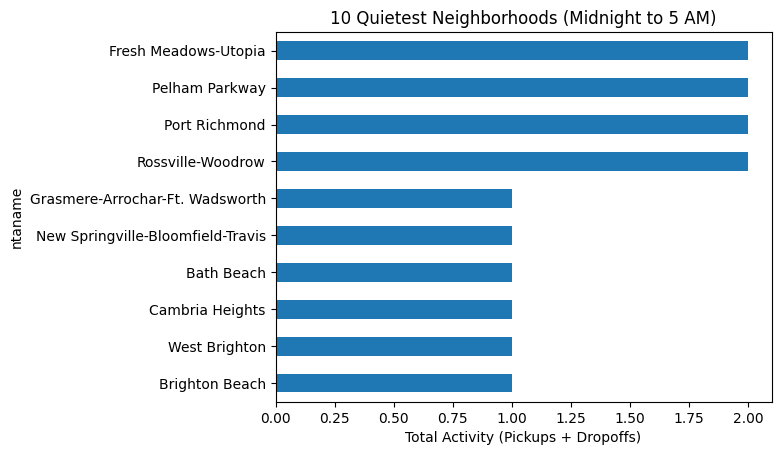

In [65]:
import pandas as pd
import geopandas as gpd

# Ensure pickup_datetime is in datetime format
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Filter for trips between midnight and 5 AM
night_trips = df[(df['pickup_datetime'].dt.hour >= 0) & (df['pickup_datetime'].dt.hour < 5)]

# Check for empty night trips data
if night_trips.empty:
    print("No night trips found for the specified time range.")
else:
    # Create GeoDataFrame for night pickups
    gdf_night_pickup = gpd.GeoDataFrame(
        night_trips, geometry=gpd.points_from_xy(night_trips.pickup_longitude, night_trips.pickup_latitude))

    # Create GeoDataFrame for night dropoffs
    gdf_night_dropoff = gpd.GeoDataFrame(
        night_trips, geometry=gpd.points_from_xy(night_trips.dropoff_longitude, night_trips.dropoff_latitude))

    # Set the coordinate reference system (CRS) to match the neighborhoods shapefile
    gdf_night_pickup.crs = nyc_neighborhoods.crs
    gdf_night_dropoff.crs = nyc_neighborhoods.crs

    # Spatial join for night pickups
    night_pickup_neighborhoods = gpd.sjoin(gdf_night_pickup, nyc_neighborhoods, how="left", predicate="within")

    # Spatial join for night dropoffs
    night_dropoff_neighborhoods = gpd.sjoin(gdf_night_dropoff, nyc_neighborhoods, how="left", predicate="within")

    # Count night pickups and dropoffs per neighborhood
    night_pickup_counts = night_pickup_neighborhoods[neighborhood_column].value_counts()
    night_dropoff_counts = night_dropoff_neighborhoods[neighborhood_column].value_counts()

    # Combine pickup and dropoff counts
    night_activity = pd.DataFrame({
        'pickups': night_pickup_counts,
        'dropoffs': night_dropoff_counts
    })

    # Fill NaN values with 0 and calculate total activity
    night_activity = night_activity.fillna(0)
    night_activity['total_activity'] = night_activity['pickups'] + night_activity['dropoffs']

    # Sort by total activity
    night_activity_sorted = night_activity.sort_values('total_activity')

    # Display the 10 quietest neighborhoods
    print("The 10 quietest neighborhoods at night (midnight to 5 AM):")
    print(night_activity_sorted.head(10))

    # Identify the quietest neighborhood(s)
    quietest_activity = night_activity_sorted['total_activity'].min()
    quietest_neighborhoods = night_activity_sorted[night_activity_sorted['total_activity'] == quietest_activity]

    print("\nThe quietest neighborhood(s) at night:")
    print(quietest_neighborhoods)

    # Optional: Visualize the quietest neighborhoods with a bar plot
    night_activity_sorted.head(10).plot(kind='barh', y='total_activity', legend=False, title='10 Quietest Neighborhoods (Midnight to 5 AM)')
    plt.xlabel('Total Activity (Pickups + Dropoffs)')
    plt.show()


The 10 busiest neighborhoods at night (midnight to 5 AM):
                                            pickups  dropoffs  total_activity
ntaname                                                                      
Midtown-Midtown South                       20328.0   13930.0         34258.0
Hudson Yards-Chelsea-Flatiron-Union Square  14560.0   10704.0         25264.0
West Village                                16540.0    8487.0         25027.0
East Village                                11408.0    6565.0         17973.0
Clinton                                      7127.0    6704.0         13831.0
SoHo-TriBeCa-Civic Center-Little Italy       7584.0    5220.0         12804.0
Chinatown                                    8782.0    3760.0         12542.0
Turtle Bay-East Midtown                      5416.0    5884.0         11300.0
Murray Hill-Kips Bay                         4610.0    6355.0         10965.0
Upper West Side                              3215.0    4436.0          7651.0

The b

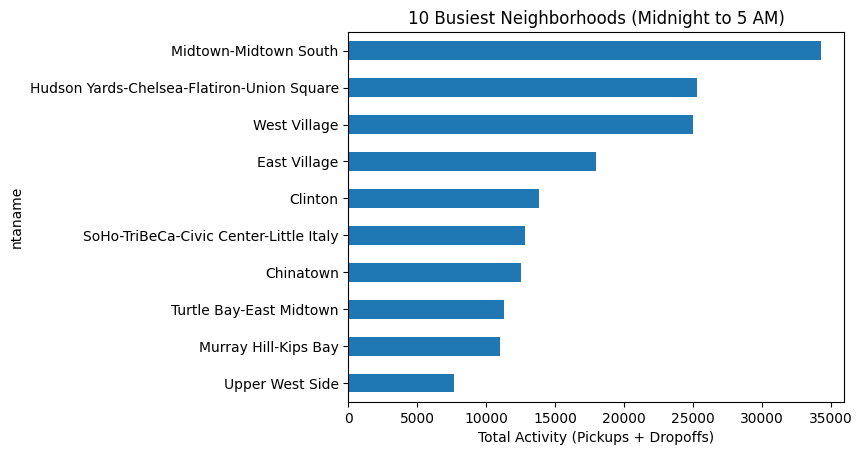

In [66]:
# Sort by total activity (descending order)
night_activity_sorted = night_activity.sort_values('total_activity', ascending=False)

# Display the 10 busiest neighborhoods
print("The 10 busiest neighborhoods at night (midnight to 5 AM):")
print(night_activity_sorted.head(10))

# Identify the busiest neighborhood(s)
busiest_activity = night_activity_sorted['total_activity'].max()
busiest_neighborhoods = night_activity_sorted[night_activity_sorted['total_activity'] == busiest_activity]

print("\nThe busiest neighborhood(s) at night:")
print(busiest_neighborhoods)

# Optional: Visualize the busiest neighborhoods with a bar plot
night_activity_sorted.head(10).plot(kind='barh', y='total_activity', legend=False, title='10 Busiest Neighborhoods (Midnight to 5 AM)')
plt.xlabel('Total Activity (Pickups + Dropoffs)')
plt.gca().invert_yaxis()  # Invert the y-axis to show the highest activity at the top
plt.show()
